In [1]:
import cvxpy as cp
import yfinance as yf
import numpy as np
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm
from scipy.linalg import sqrtm

In [2]:
with open("tickers.txt", 'r') as f:
    tickers = f.read().splitlines()[:100]

In [3]:
start = "2020-01-01"
end = "2020-12-31"
holding_period = 20

returns = {}
histories = []
for ticker in tqdm(tickers):
    history = yf.Ticker(ticker).history(start=start, end=end)
    histories.append(history)

100%|██████████| 100/100 [00:15<00:00,  6.47it/s]


## 1. Gather data
Compute the historical returns for the top 100 (alphabetical) S&P stocks over 200 random twenty day periods in 2020, & the covariance matrix of these returns.

In [4]:
def calc_returns(histories, n, seed=10):
    np.random.seed(seed)
    return_vecs = []
    for _ in tqdm(range(n)):
        start_day = np.random.choice(365 - holding_period)
        start_stamp = np.datetime64(start) + np.timedelta64(start_day, 'D')
        end_stamp = start_stamp + np.timedelta64(holding_period, 'D')
        
        return_vec = []
        for history in histories:
            start_index = np.argmax(history.index >= start_stamp)
            end_index = np.argmax(history.index >= end_stamp)

            start_close, end_close = history.iloc[[start_index, end_index]]['Close'].values
            pct_return = end_close/start_close
            return_vec.append(pct_return)
            
        return_vecs.append(return_vec)
    return np.asarray(return_vecs)
        
replicates = 1000
returns = calc_returns(histories, replicates)
returns = np.append(returns, np.ones((replicates, 1)), 1)
full_means = np.mean(returns, axis=0)
full_cov = np.cov(returns.T)

100%|██████████| 1000/1000 [00:42<00:00, 23.48it/s]


Note the outlier `CZR` - this stock cratered in early 2020 but recovered quickly. This outlier will come up later.

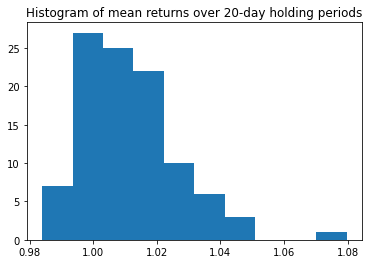

In [5]:
plt.hist(full_means)
plt.title("Histogram of mean returns over 20-day holding periods")
plt.show()

## 2. Minimizing fixed plus linear transaction costs

### 2.1 Compute lower and upper bounds on each transaction
To compute transaction bounds, we take advantage of the constraint on the variance of portfolio return. The bounds will depend on how much variance we are comfortable with, i.e. $\sigma$. The upper bound is given by

$$
\begin{align*}
\text{maximize} \quad & x_i\\
\text{subject to} \quad & g(x) = (w + x)^T\Sigma(w + x) - \sigma^2 \leq 0
\end{align*}
$$

The calculation is omitted in the paper but we do it here for practice. The Lagrangian is
\begin{equation*}
L(x, \lambda) = e_i^T x  - \lambda((w + x)^T\Sigma(w + x) - \sigma^2).
\end{equation*}
Maximizing over $x$ yields
\begin{equation*}
x = \frac{\Sigma^{-1}e_i}{2\lambda} - w
\end{equation*}
Resubstituting into the Lagrangian to eliminate the dependence on $x$ and simplifying, we have
\begin{equation*}
L(\lambda) = \frac{e_i^T \Sigma^{-1} e_i}{4\lambda} - e_i^T w + \lambda \sigma^2
\end{equation*}
which achieves its maximum at 
\begin{equation*}
\lambda = \frac{\sqrt{(\Sigma^{-1})_{ii}}}{2\sigma}
\end{equation*}
so that $x_i = \sigma\sqrt{(\Sigma^{-1})_{ii}} - w_i$ is optimal. Mutatis mutandis, the lower bound is $x_i = -\sigma\sqrt{(\Sigma^{-1})_{ii}} - w_i$. For the lower bound, we use this value or the short selling lower bound, whichever is larger.

For this example, we use 10 stocks and one riskless asset, following the paper, so that the global optimum can be computed combinatorially.

### 2.2 Solve relaxed problem to get an initial guess
Following the paper, we solve
$$
\begin{align*}
\text{minimize} \quad & \sum_{i=1}^n \phi_i^{\text{c.e.}}(x_i)\\
\text{subject to} \quad & \overline{a}^T(w+x) \geq r_{\text{min}}
\end{align*}
$$
The convex envelope function $\phi_i^{\text{c.e.}}$, which is the largest convex function less than or equal to $\phi_i$, is given by
$$
\phi_i^{\text{c.e.}}(x_i) = \begin{cases}
\left(\frac{\beta_i}{u_i} + \alpha_i\right)x_i, & x_i \geq 0\\
-\left(\frac{\beta_i}{l_i} + \alpha_i\right)x_i, & x_i \leq 0
\end{cases}
$$

### 2.3 Run iterative algorithm

Just as in the paper, we find that the algorithm converges in around 4 iterations.

In [6]:
def setup_params(sigma, indices, full_means, full_cov, short):
    # last index is assumed to be that of the riskless asset
    n = len(indices)
    alpha = np.repeat(.01, n)
    alpha[-1] = 0

    beta = np.repeat(.01, n)
    beta[-1] = 0

    s = np.repeat(short[0], n)
    s[-1] = short[1]

    w = np.repeat(1/n, n)
    
    delete_indices = list(set(range(len(full_cov))) - set(indices))
    cov = np.delete(np.delete(full_cov, delete_indices, axis=1), delete_indices, axis=0)

    # compute bounds
    u = sigma*np.sqrt(np.diag(np.linalg.inv(cov + 1e-8))) - w
    l = np.max(np.vstack([-u - 2*w, s]), axis=0)

    a_bar = full_means[indices]
    return alpha, beta, s, w, u, l, cov, a_bar

In [7]:
def iterative_portfolio_optimization(sigma,
                                     indices,
                                     full_means,
                                     full_cov,
                                     shortfall_risk_constraints=None,
                                     optimize_return=True,
                                     r_min=1.01,
                                     verbose=False,
                                     max_iter=10000,
                                     chebyshev=False,
                                     tighten=1,
                                     short=(.05, .5),
                                     dry_run=False):
    if shortfall_risk_constraints is None:
        shortfall_risk_constraints = []
    
    alpha, beta, s, w, u, l, cov, a_bar = setup_params(
        sigma, indices, full_means, full_cov, short)
    
    if dry_run:
        # solve the problem without transaction costs or the end-period return variance constraint
        alpha = 0
        beta = 0
        sigma = 100
    
    x = cp.Variable(len(indices))
    
    # 2.2 compute initial guess
    phi_ce_positive_region = cp.maximum(0, cp.multiply(x, (alpha + beta/u)))
    phi_ce_negative_region = cp.maximum(0, cp.multiply(x, -(alpha + beta/l)))
    phi_ce = cp.maximum(phi_ce_positive_region, phi_ce_negative_region)

    constraints = [cp.quad_form(w + x, cov) - sigma**2 <= 0,
                   cp.sum(x) + cp.sum(phi_ce) <= 0,
                   -s - x - w <= 0]
    
    for constraint in shortfall_risk_constraints:
        eta, W_low = constraint
        if chebyshev:
            factor = (1 - eta)**(-.5)
            factor *= tighten
        else:
            factor = norm.ppf(eta)
        
        constraints.append(factor*cp.norm(sqrtm(cov)@(w + x)) <= 
                         a_bar.T@(w + x) - W_low)

    if optimize_return:
        objective = cp.Maximize(a_bar.T@(w + x))
    else:
        objective = cp.Minimize(cp.sum(phi_ce))
        constraints.append(a_bar.T@(w + x) >= r_min)

    prob = cp.Problem(objective, constraints)
    result = prob.solve()

    x_k = x.value
    if dry_run:
        return x_k, a_bar.T@(w + x_k)
    
    # 2.3 run iterative algorithm
    k = 1
    delta = .001
    tolerance = 1e-8
    
    if x_k is None:
        print("Failed to solve initial guess problem")
        return (None, 0)
    
    if verbose:
        print(x_k)

    converged = False
    while not converged:        
        if verbose:
            print(f"Iteration {k}")
        k += 1

        x = cp.Variable(len(indices))
        phi_hat_k = cp.multiply(cp.abs(x), alpha + beta/(np.abs(x_k) + delta))
        
        constraints = [cp.quad_form(w + x, cov) - sigma**2 <= 0,
                       cp.sum(x) + cp.sum(phi_hat_k) <= 0,
                       -s - x - w <= 0]

        if optimize_return:
            objective = cp.Maximize(a_bar.T@(w + x))
        else:
            objective = cp.Minimize(cp.sum(phi_hat_k))
            constraints.append(a_bar.T@(w + x) >= r_min)
            
        for constraint in shortfall_risk_constraints:
            if chebyshev:
                factor = (1 - eta)**(-.5)
                factor *= tighten
            else:
                factor = norm.ppf(eta)

            eta, W_low = constraint
            constraints.append(factor*cp.norm(sqrtm(cov)@(w + x)) <= 
                             a_bar.T@(w + x) - W_low)
            
        prob = cp.Problem(objective, constraints)
        result = prob.solve()

        x_k_plus_1 = x.value
        if x_k_plus_1 is None or k > max_iter:
            # if the problem becomes infeasible, return the answer for the last feasible iteration
            print("Iterative scheme was infeasible; use with caution")
            return (x_k, a_bar.T@(w + x_k))

        if np.sum(np.abs(x_k_plus_1 - x_k)) <= tolerance:
            converged=True
        else:
            x_k = x_k_plus_1
            
    return x_k_plus_1, a_bar.T@(w + x_k_plus_1)

When we maximize return, we go short in many other assets, in addition to the riskless asset, to finance increased risk in the high return asset.

In [8]:
indices = list(range(90,101))
maximum_return_allocation, best_return = iterative_portfolio_optimization(.2, indices, full_means, full_cov, optimize_return=True)
maximum_return_allocation, best_return

(array([ 1.45206035e-12,  2.90226586e-12,  5.75174505e-01,  2.38696585e-12,
         2.26582258e-12,  3.60000915e-12,  2.88137126e-12,  1.26905490e-12,
         2.09990952e-12,  2.04169773e-12, -5.90908885e-01]),
 1.0120549327649297)

### 2.4 Combinatorial Solution
With just 10 stocks, we can solve the problem combinatorially and compare the solution that we know to be optimal with the heuristic solution.

In [9]:
from itertools import chain, combinations
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def compute_true_optimum(sigma,
                         indices,
                         full_means,
                         full_cov,
                         shortfall_risk_constraints=None,
                         chebyshev=False,
                         short=(.05, .5),
                         verbose=False):
    # to compute the true optimum, we solve 2^10 convex optimization problems
    alpha, beta, s, w, u, l, cov, a_bar = setup_params(sigma, indices, full_means, full_cov, short)
    transact_in = powerset(list(range(10)))
    
    if shortfall_risk_constraints is None:
        shortfall_risk_constraints = []
    
    best = (None, 0)
    
    if verbose:
        transact_in = tqdm(transact_in)
    
    for transact_indices in transact_in:        
        # we always have the option to transact in the riskless asset
        transact_indices = list(transact_indices)
        transact_indices.append(10)
        
        x = cp.Variable(len(transact_indices))
        
        mask = np.zeros(11, dtype=bool)
        mask[transact_indices] = True
        
        a_bar_transact = a_bar[mask]
        alpha_transact = alpha[mask]
        beta_transact = beta[mask]
        s_transact = s[mask]
        w_transact = w[mask]
        
        design = np.zeros((11,len(transact_indices)))
        for i in range(len(transact_indices)):
            design[transact_indices[i]][i] = 1
        
        objective = cp.Maximize(a_bar.T@(w + design@x))
        constraints = [cp.sum(x) + cp.sum(cp.multiply(cp.abs(x), alpha_transact)) +\
                       (len(transact_indices) - 1)*beta[0] <= 0]
        constraints.append(-s_transact - (x + w_transact) <= 0)
        constraints.append(cp.quad_form(w + design@x, cov) - sigma**2 <= 0)
        
        for constraint in shortfall_risk_constraints:
            eta, W_low = constraint
            if chebyshev:
                factor = (1 - eta)**(-.5)
            else:
                factor = norm.ppf(eta)
            
            constraints.append(factor*cp.norm(sqrtm(cov)@(w + x)) <= 
                             a_bar.T@(w + x) - W_low)

        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        
        if x.value is None:
            continue
        
        cur_return = a_bar.T@(w + design@x.value)
        if cur_return > best[-1]:
            best = (design@x.value, a_bar.T@(w + design@x.value))
            
    return best

### 2.5 Compute tradeoff between maximum average return and acceptable risk

In [10]:
# to get a nicer looking plot, increase this number - takes about 15s to compute each
# optimal solution on my PC - heuristic is comparatively very fast (< 1s per solution)
num_sigmas = 10 
indices = list(range(90, 101))
sigmas = np.linspace(0, .4, num_sigmas)

heuristic_results = [iterative_portfolio_optimization(
    sigma, indices, full_means, full_cov, optimize_return=True, verbose=False)
           for sigma in tqdm(sigmas)]

heuristic_allocations, heuristic_returns = zip(*heuristic_results)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
100%|██████████| 10/10 [00:21<00:00,  2.12s/it]


In [11]:
optimal_results = [compute_true_optimum(sigma, indices, full_means, full_cov)
                       for sigma in tqdm(sigmas)]

optimal_allocations, optimal_returns = zip(*optimal_results)

100%|██████████| 10/10 [02:43<00:00, 16.37s/it]


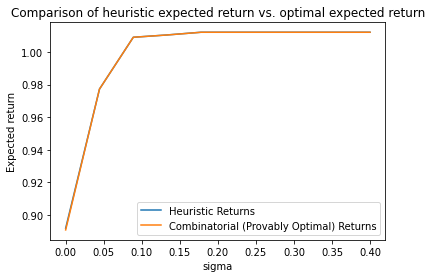

In [12]:
import matplotlib.pyplot as plt
plt.plot(sigmas, heuristic_returns, label= "Heuristic Returns")
plt.plot(sigmas, optimal_returns, label="Combinatorial (Provably Optimal) Returns")
plt.legend()
plt.title("Comparison of heuristic expected return vs. optimal expected return")
plt.xlabel("sigma")
plt.ylabel("Expected return")
plt.show()

## 2.6 Role of the short position constraint
Note that for our holdings in each risky asset $i$ we have a short constraint $w_i + x_i \geq -.05$, and for the riskless asset $w_i + x_i \geq -.5$. We see in the above return tradeoff curves that the optimal return flatlines after a certain point - this is because, even allowing massive final return variance, we cannot increase our risk (and thus our return) without deepening our short positions in the riskless asset or in stocks with meager return.

Note that double the maximum short position in each stock ($.05 \to .1$) and riskless asset ($.5 \to 1$), the curve flattens later.

In [13]:
heuristic_results_deepshort = [iterative_portfolio_optimization(
    sigma, indices, full_means, full_cov, optimize_return=True, short=(.1, 1), verbose=False)
           for sigma in tqdm(sigmas)]

heuristic_allocations_deepshort, heuristic_returns_deepshort = zip(*heuristic_results_deepshort)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
 30%|███       | 3/10 [02:22<04:18, 36.89s/it] 

Iterative scheme was infeasible; use with caution


100%|██████████| 10/10 [02:22<00:00, 14.28s/it]


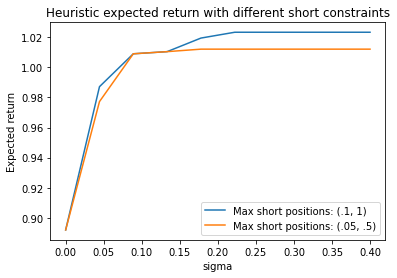

In [14]:
plt.plot(sigmas, heuristic_returns_deepshort, label="Max short positions: (.1, 1)")
plt.plot(sigmas, heuristic_returns, label="Max short positions: (.05, .5)")
plt.title("Heuristic expected return with different short constraints")
plt.xlabel("sigma")
plt.ylabel("Expected return")
plt.legend()
plt.show()

## 2.7 Sensitivity Analysis
Above we arbitrarily selected the last 10 stocks in the top 100 alphabetical stocks of the S&P 500. How much do optimal returns for a given variance depend on the bundle of stocks we start with? I.e., pick 10 stocks at random from the top 100? Answer: a lot

In [15]:
num_stock_choices = 100

best_returns = []
best_allocations = []
indices_choices = []
for i in tqdm(range(num_stock_choices)):
    random_indices = np.random.choice(100, 10, replace=False).tolist() + [100]
    maximum_return_allocation, best_return = iterative_portfolio_optimization(
        .2, random_indices, full_means, full_cov, optimize_return=True, verbose=False)
    best_returns.append(best_return)
    best_allocations.append(maximum_return_allocation)
    indices_choices.append(random_indices)

100%|██████████| 100/100 [00:09<00:00, 10.33it/s]


Note the wide variance as well as the outliers around $.19$ - we find that all the outlier portfolios have `CZR` (77) and the riskless asset (100) (and no other assets) in common - `CZR` has an abnormally high return, probably due to having cratered in early 2020 and then recovered.

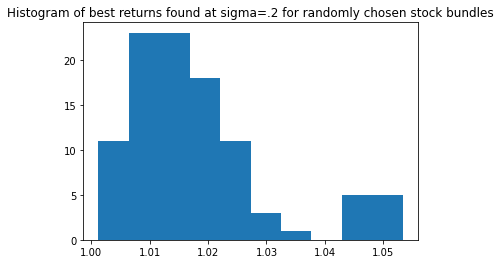

In [16]:
plt.hist(best_returns)
plt.title("Histogram of best returns found at sigma=.2 for randomly chosen stock bundles")
plt.show()

In [17]:
from functools import reduce
from collections import Counter
reduce(lambda x, y: Counter(x) + Counter(y),
       [set(indices_choices[i]) for i in np.where(np.asarray(best_returns) > 1.04)[0]]).most_common(2)

[(100, 10), (77, 10)]

## 3. Shortfall Constraints
### 3.1 Normally distributed returns
When we assume that the returns are normally distributed, the paper notes that "end of period wealth is a Gaussian random variable." So we can impose a shortfall constraint, i.e. a constraint which specifies that the end of period wealth exceed some undesired level $W_{\text{low}}$ with probability $\eta$. The constraint is
$$
\Pr \left(\frac{W - \mu}{\sigma} \leq \frac{W_{\text{low}} - \mu}{\sigma} \right) \leq 1 - \eta.
$$
Since $(W - \mu)/\sigma$ is a normally distributed Gaussian variable, the LHS is just $\Phi\left(\frac{W_{\text{low}} - \mu}{\sigma}\right)$, where $\Phi$ is the Gaussian CDF. Then taking the inverse CDF of both sides, the constraint is
$$
\frac{W_{\text{low}} - \mu}{\sigma} \leq \Phi^{-1}(1 - \eta)
$$
or equivalently
$$
\mu - W_{\text{low}} \geq \Phi^{-1}(\eta)\sigma.
$$
Susbstituting $\mu = \overline{a}^T(w + x)$ and $\sigma^2 = (w + x)^T\Sigma(w + x)$, we get
$$
\overline{a}^T(w + x) - W_{\text{low}} \geq \Phi^{-1}(\eta) \|\Sigma^{1/2}(w + x)\|_2,
$$
which is a second order cone constraint.

Following the paper, we start off with two shortfall risk constraints, a modestly confident constraint on a low return and a very confident constraint on a "disastrous" return.
$$
\eta_1 = .8,\quad W_1^{\text{low}} = .8; \text{ and }\eta_2 = .97, W_2^{\text{low}} = .7
$$

In [18]:
indices = list(range(90,101))
iterative_portfolio_optimization(
    .2,
    indices,
    full_means,
    full_cov,
    shortfall_risk_constraints=[(.8, .8), (.97, .7)],
    optimize_return=True)

(array([6.43588811e-13, 7.25092714e-13, 6.86439117e-13, 6.54279921e-13,
        7.22761376e-13, 6.83100428e-13, 6.95030410e-13, 6.15048609e-13,
        6.78609850e-13, 6.82103673e-13, 3.57746896e-10]),
 1.0089791008813196)

We can also ask how increasing the confidence of a shortfall constraint affects optimal return.

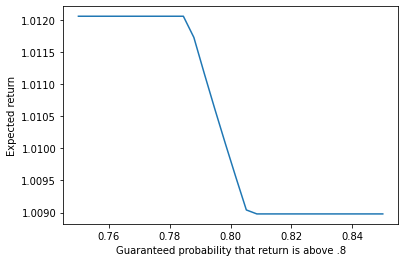

In [19]:
etas = np.linspace(.75,.85, 30)
shortfall_results = [iterative_portfolio_optimization(
    .2,
    indices,
    full_means,
    full_cov,
    shortfall_risk_constraints=[(eta, .9)],
    optimize_return=True) for eta in etas]
                     
shortfall_allocations, shortfall_returns = zip(*shortfall_results)

plt.plot(etas, shortfall_returns)
plt.xlabel("Guaranteed probability that return is above .8")
plt.ylabel("Expected return")
plt.show()

Finally, we can ask how the addition of a shortfall constraint affects the optimal return for different values of $\sigma$.

The fact that the two curves coincide, then diverge is not surprising, since there is a correspondence between shortfall constraints and constraints on the variance of the final return. If we allow the variance to increase, then the portfolios diverge because the variance constraint no longer dominates the shortfall constraint.

100%|██████████| 10/10 [00:00<00:00, 11.46it/s]


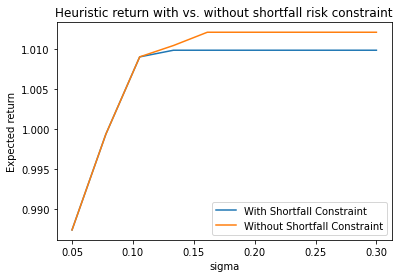

In [20]:
sigmas_wide = np.linspace(.05, .3, 10)
shortfall_results_wide = [iterative_portfolio_optimization(
    sigma,
    indices,
    full_means,
    full_cov,
    shortfall_risk_constraints=[(.8, .9)],
    optimize_return=True) for sigma in sigmas_wide]
shortfall_allocations_wide, shortfall_returns_wide = zip(*shortfall_results_wide)

heuristic_results_wide = [iterative_portfolio_optimization(
    sigma,
    indices,
    full_means,
    full_cov,
    optimize_return=True,
    verbose=False) for sigma in tqdm(sigmas_wide)]
heuristic_allocations_wide, heuristic_returns_wide = zip(*heuristic_results_wide)

plt.plot(sigmas_wide, shortfall_returns_wide, label="With Shortfall Constraint")
plt.plot(sigmas_wide, heuristic_returns_wide, label="Without Shortfall Constraint")
plt.xlabel("sigma")
plt.ylabel("Expected return")
plt.title("Heuristic return with vs. without shortfall risk constraint")
plt.legend()
plt.show()

### 3.2 Investigating the normality assumption
The shortfall constraint relies on the assumption that the returns for a given stock over an arbitrary 20 day holding period are normally distributed. As the paper authors indicate, this is dubious - they write, ""observed returns are seldom Gaussian. They are often skewed, or have "fat tails", i.e. resemble a Gaussian distribution in the central area but have higher probability mass for high deviations.

Suppose we are generous and exclude the outlier `CZR` from our analysis. One way to test for normality of a given stock would be to generate normally distributed data with the same mean and variance as one of our stocks, then check what percentage of the time this sample has kurtosis (a measure of fat-tailedness) as or more extreme than the stock's data.

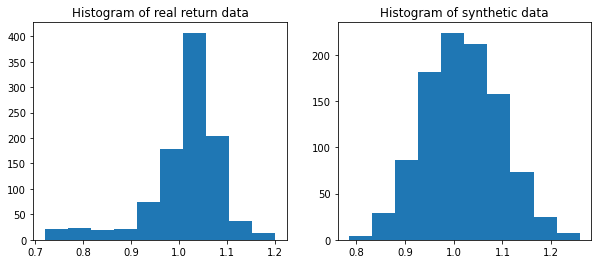

In [21]:
stock_choice = 3
stock = returns[:,stock_choice]
mean = full_means[stock_choice]
variance = full_cov[stock_choice][stock_choice]

plt.subplots(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(stock)
plt.title("Histogram of real return data")

plt.subplot(1,2,2)
replicate = np.random.normal(mean, np.sqrt(variance), size=1000)
plt.hist(replicate)
plt.title("Histogram of synthetic data")

plt.show()

For some stocks the difference is clearer than others.

In [22]:
from scipy.stats import kurtosis, percentileofscore

percentiles = []
for stock_choice in tqdm(range(100)):
    stock = returns[:,stock_choice]
    mean = full_means[stock_choice]
    variance = full_cov[stock_choice][stock_choice]
    kurtosis_reps = []
    for i in range(1000):
        replicate = np.random.normal(mean, np.sqrt(variance), size=len(stock))
        kurtosis_reps.append(kurtosis(replicate))

    percentiles.append(percentileofscore(kurtosis_reps, kurtosis(stock)))

100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


For most stocks, the 20-day-return data's kurtosis is within the 90th-100th percentile of normally-distributed replicates with the same mean and variance. So not only are the data not normal, but our current shortfall constraints are particularly useless because our data have such fat tails.

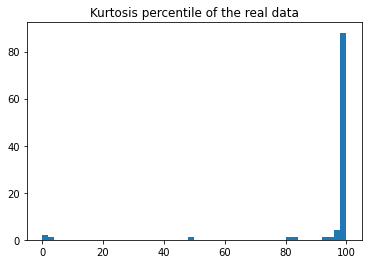

In [23]:
plt.hist(percentiles, bins=50)
plt.title("Kurtosis percentile of the real data")
plt.show()

### 3.3 Chebyshev Bound

Assuming $W_{\text{low}} \leq \mu$, we have
$$
\Pr(W \leq W_{\text{low}}) \leq \Pr(|W - \mu| \geq |W_{\text{low}} - \mu|)
$$
so that by Chebyshev's inequality,
$$
\Pr(W \leq W_{\text{low}}) \leq \frac{\sigma^2}{(W_{\text{low}} - \mu)^2}.
$$
We bound the LHS above by $1 - \eta$ - substituting for $\sigma$ and $\mu$, rearranging, and taking the square root of both sides, we get
$$
(1 - \eta)^{-1/2} \| \Sigma^{1/2} (w + x)\| \leq \overline{a}^T(w + x) - W_{\text{low}}.
$$

In [24]:
sigmas_wide = np.linspace(.05,.3,30)
shortfall_results_chebyshev = [iterative_portfolio_optimization(
    sigma,
    indices,
    full_means,
    full_cov,
    shortfall_risk_constraints=[(.8, .8)],
    chebyshev=True,
    optimize_return=True) for sigma in sigmas_wide]
shortfall_allocations_chebyshev, shortfall_returns_chebyshev = zip(*shortfall_results_chebyshev)

shortfall_results_normal = [iterative_portfolio_optimization(
    sigma,
    indices,
    full_means,
    full_cov,
    shortfall_risk_constraints=[(.8, .8)],
    optimize_return=True) for sigma in sigmas_wide]
shortfall_allocations_normal, shortfall_returns_normal = zip(*shortfall_results_normal)

heuristic_results_wide = [iterative_portfolio_optimization(
    sigma,
    indices,
    full_means,
    full_cov,
    optimize_return=True) for sigma in tqdm(sigmas_wide)]
heuristic_allocations_wide, heuristic_returns_wide = zip(*heuristic_results_wide)

100%|██████████| 30/30 [00:02<00:00, 10.89it/s]


Note that for comparable $(\eta, W_{\text{low}})$ pairs, the Chebyshev shortfall constraint is stricter than the normal shortfall constraint.

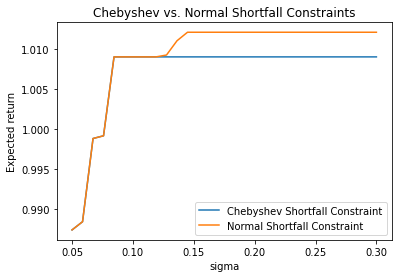

In [25]:
plt.plot(sigmas_wide, shortfall_returns_chebyshev, label="Chebyshev Shortfall Constraint")
plt.plot(sigmas_wide, shortfall_returns_normal, label="Normal Shortfall Constraint")
plt.xlabel("sigma")
plt.ylabel("Expected return")
plt.title("Chebyshev vs. Normal Shortfall Constraints")
plt.legend()

plt.show()

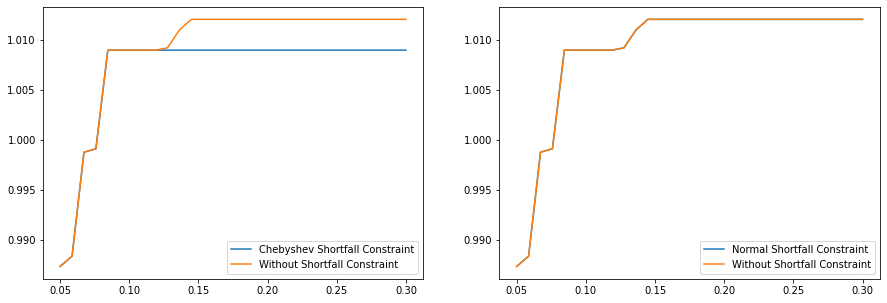

In [26]:
plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(sigmas_wide, shortfall_returns_chebyshev, label="Chebyshev Shortfall Constraint")
plt.plot(sigmas_wide, heuristic_returns_wide, label="Without Shortfall Constraint")
plt.legend()

plt.subplot(1,2,2)
plt.plot(sigmas_wide, shortfall_returns_normal, label="Normal Shortfall Constraint")
plt.plot(sigmas_wide, heuristic_returns_wide, label="Without Shortfall Constraint")
plt.legend()
plt.show()

Right now we claim to be able to get around 1% return at $\sigma=.2$. However, since the sample returns are draws from a random distribution, this is just an estimate. In particular, the shortfall constraint could be too lenient, or too harsh, depending on whether the samples we drew were representative of the distribution. (While many parts of of our solution depend on values estimated from sample data which are thus uncertain, we draw attention to the shortfall constraint because it seems particularly likely to lull us into a false sense of security.)

To get an idea of the uncertainty in the optimal return we can claim for a particular set of stocks, one strategy would be to repeatedly solve the problem with a bootstrap replicate of the original return data.

In [27]:
results = []
for _ in tqdm(range(100)):
    returns_replicate = np.asarray([np.random.choice(returns[:,i], len(returns), replace=True)
                                    for i in range(len(returns[0]))]).T
    full_means_replicate = np.mean(returns_replicate, axis=0)
    full_cov_replicate = np.cov(returns_replicate.T)

    results.append(iterative_portfolio_optimization(
        .2,
        indices,
        full_means_replicate,
        full_cov_replicate,
        shortfall_risk_constraints=[(.8, .8)],
        chebyshev=True,
        optimize_return=True))
    
bootstrap_allocations, bootstrap_returns = zip(*results)

100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


If the boostrap approach is valid, then it appears that the return of 1% we saw above is fairly typical. So for these stocks, this strategy would net on average a 1% return over twenty days (12% annualized), with roughly 80% confidence that the portfolio return will not dip below .8

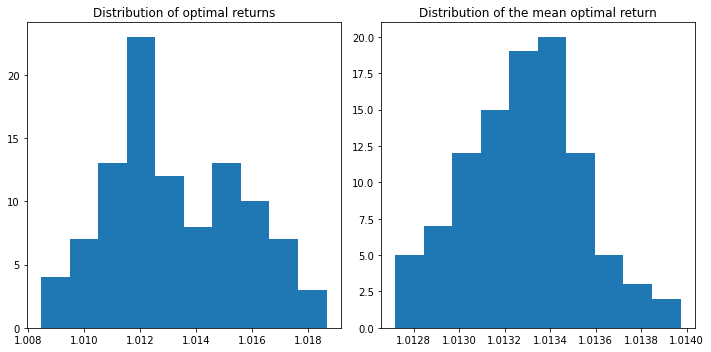

In [28]:
plt.subplots(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(bootstrap_returns)
plt.title("Distribution of optimal returns")

plt.subplot(1,2,2)
return_mean_replicates = []
for _ in range(100):
    return_mean_replicate = np.mean(np.random.choice(bootstrap_returns, 100, replace=True))
    return_mean_replicates.append(return_mean_replicate)
plt.hist(return_mean_replicates)
plt.title("Distribution of the mean optimal return")
plt.tight_layout()
plt.show()

## 3.4 Tightening the Chebyshev Bound
The Chebyshev bound computed above is computed with the following step:
$$\Pr(W \leq W_{\text{low}}) \leq \Pr(|W - \mu| \geq |W_{\text{low}} - \mu|)$$
We invoke Chebyshev to dominate the right hand side. However, we are potentially giving up a lot of slack with the inequality above. Concretely, if the distribution is symmetric, then
$$
\Pr(W \leq W_{\text{low}}) = \frac{1}{2}\Pr(|W - \mu| \geq |W_{\text{low}} - \mu|)
$$
so that the original constraint has us dominating a quantity twice as large as necessary. If the distribution of returns is end-period returns is relatively symmetric, then we can tighten the bound. The distribution of end-period returns will be symmetric if each individual stock has a symmetric return distribution.

100%|██████████| 30/30 [00:02<00:00, 10.49it/s]


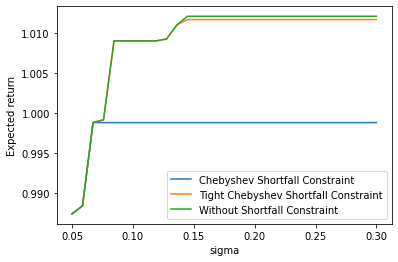

In [29]:
shortfall_results_tight = [iterative_portfolio_optimization(
    sigma,
    indices,
    full_means,
    full_cov,
    shortfall_risk_constraints=[(.95, .7)],
    chebyshev=True,
    tighten=.5,
    optimize_return=True) for sigma in sigmas_wide]
shortfall_allocations_tight, shortfall_returns_tight = zip(*shortfall_results_tight)

shortfall_results_chebyshev = [iterative_portfolio_optimization(
    sigma,
    indices,
    full_means,
    full_cov,
    shortfall_risk_constraints=[(.95, .7)],
    chebyshev=True,
    tighten=1,
    optimize_return=True) for sigma in sigmas_wide]
shortfall_allocations_chebyshev, shortfall_returns_chebyshev = zip(*shortfall_results_chebyshev)

heuristic_results_wide = [iterative_portfolio_optimization(
    sigma,
    indices,
    full_means,
    full_cov,
    optimize_return=True) for sigma in tqdm(sigmas_wide)]
heuristic_allocations_wide, heuristic_returns_wide = zip(*heuristic_results_wide)

plt.plot(sigmas_wide, shortfall_returns_chebyshev, label="Chebyshev Shortfall Constraint")
plt.plot(sigmas_wide, shortfall_returns_tight, label="Tight Chebyshev Shortfall Constraint")
plt.plot(sigmas_wide, heuristic_returns_wide, label="Without Shortfall Constraint")
plt.xlabel("sigma")
plt.ylabel("Expected return")
plt.legend()
plt.show()

## 3.5 Justifying the Tightening
For the tightening to be justified, we must be able to say that
$$
\Pr(W \leq W_{\text{low}}) \leq \frac{1}{2}\Pr(|W - \mu| \geq |W_{\text{low}} - \mu|).
$$
This occurs either when the distribution is symmetric (exact equality) or when there is relatively more mass above $\mu + (\mu - W_{\text{low}})$ than below $W_{\text{low}}$. For a range of values for $W_{\text{low}}$, we can estimate the fraction 
$$\Pr(W \leq W_{\text{low}})/(\Pr(W \leq W_{\text{low}}) + \Pr(W \geq 2\mu - W_{\text{low}}));
$$
if it is below .5, the tightening is justified. It appears that as $W_{\text{low}}$ decreases, the fraction decreases; i.e. the tightening is more justified for more relaxed shortfall constraints.

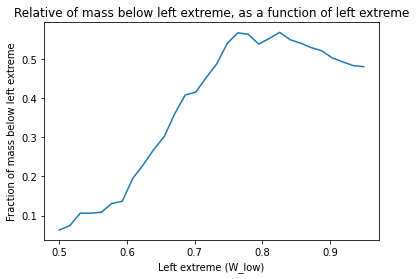

In [30]:
lows = np.linspace(.5, .95, 30)
mean_fracs = []
for low in lows:
    counts = [(np.sum(returns[:,i] <= low), np.sum(returns[:,i] >= 2*np.mean(returns[:,i]) - low)) for i in range(101)]
    low_fracs = [count[0]/(count[0] + count[1] + 1e-8) for count in counts]
    
    frac = np.mean(low_fracs)
    mean_fracs.append(frac)
    
plt.plot(lows, mean_fracs)
plt.title("Relative of mass below left extreme, as a function of left extreme")
plt.xlabel("Left extreme (W_low)")
plt.ylabel("Fraction of mass below left extreme")
plt.show()